# Strain Mapping 

This notebook goes through the steps to calculate the strain using pyxem.  This data was taken from the paper:

```
Microstructure and microchemistry study of irradiation-induced precipitates in proton irradiated ZrNb alloys
Yu, Zefeng; Zhang, Chenyu; Voyles, Paul M.; He, Lingfeng; Liu, Xiang; Nygren, Kelly; Couet, Adrien
10.18126/2nj3-gyd8 
```

It shows a percipitate which arises from irradiation in the ZrNb sample.  The dataset shows the strain for one of these precipitates.  The results in this notebook are slightly different than those published as the paper only uses two diffraction spots to calculate strain.  Here we define a `basis` set of diffraction spots from an unstrained region of the sample and then use that basis set of spots to refine the diffraction spots found in the rest of the dataset.

Then a gradient tensor which maps each set of found points at (x,y) is calculated such that the tensor maps the points onto the basis.

Transforming that gradient tensor we can plot the percent strain in the E11 E22 and E33 directions as well as a Theta displacement. 

In this sample you can see that there is mostly compressive stress on the percipite as well as shear stress. Hot spots on the edge of the theta map suggest the presence of dislocations as well. 
<center><img src="Images/Strain Mapping.png" alt="StrainMapping" height="1000" width="1000"></center>

In [1]:
import hyperspy.api as hs

In [4]:
import pyxem
print(pyxem.__version__)

0.18.0


In [1]:
# import hyperspy

In [2]:
# Load the data
s = pxm.data.zrnb_precipitate(allow_download=True)

In [35]:
# set axis labels
s.axes_manager.signal_axes[0].name="kx"
s.axes_manager.signal_axes[1].name="ky"

In [3]:
# Set the figure dpi so that things show up nicely side by side (This is different for every monitor. 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 60

In [4]:
# plot the dataset (use ipympl)

## Lets Average the Signal a Bit...

Sometimes we see some varible intensity in the disks.  We can actually correct some of this by just gaussian filtering the data in real space.  
For strain mapping we can make this very local (sigma = 1.,1.0,0.0,0.0) and we don't lose much spatial resolution. Of course you can also just take longer exposures to get more signal to noise ratio!  

There are other things you can do.  

In [5]:
#from dask_image.ndfilters import gaussian_filter # For lazy signals
from scipy.ndimage import gaussian_filter

In [136]:
# filter the dataset
filtered = s.filter(gaussian_filter, sigma=(1,1,0,0)) # in pixels 

In [138]:
filtered

<ElectronDiffraction2D, title: , dimensions: (60, 40|256, 256)>

In [139]:
# plot the filtered dataset (Lets compare the two!)
filtered.plot(vmax="99th")
s.plot(axes_manager=filtered.axes_manager, vmax="99th")


In [186]:
plt.close("all")

## Aside:  I want to try a Hough Transform!

Okay I personally am I little bit hisitent about the Hough Transform.  Most of the time the reason that people see better performance from the Hough transform over Template matching is that they are not doing a cross-correlation which properly normalizes for noise.  The Hough transform also requires very high signal to noise, requires you to mask your data in some way (which also explains better performance).  Template matching will handle fluctuations in the disks as long as you normalize correctly (which pyxem currently does quite well in my opinion)

You can find the peaks from the circular_hough signal in the same way we normally find peaks. This functionality isn't currently baked into `pyxem` but if people are interested in this you can raise an issue and it is an easy addition. 

In [182]:
from skimage.transform import hough_circle
from skimage.feature import canny
import numpy as np

def hough_circle_single_rad(img, radius,sigma=3, **kwargs):
    return hough_circle(img, radius, **kwargs)[0] # Otherwise the returned 

In [178]:
canny_img = filtered.map(canny, sigma=3, low_threshold=.6, high_threshold=.8, inplace=False, use_quantiles=True)

[########################################] | 100% Completed | 105.75 ms
[########################################] | 100% Completed | 15.14 s
[########################################] | 100% Completed | 15.17 s


In [179]:
canny_img.plot()

In [183]:
circular_hough = canny_img.map(hough_circle_single_rad, radius=11, inplace=False)

[########################################] | 100% Completed | 112.40 ms
[########################################] | 100% Completed | 1.86 ss
[########################################] | 100% Completed | 1.96 s


In [185]:
canny_img.plot()
circular_hough.plot(axes_manager=canny_img.axes_manager)

/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/hyperspy/drawing/utils.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**kwargs)


/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/hyperspy/drawing/utils.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**kwargs)


## Filtering with a Disk Template Matching

Then we can use template matching before finding the diffraction vectors in the dataset.  I like to do this lazily and then adjust the parameters.  The disk_r can be read from the size of the direct beam but it is also good to view the template result to make sure that things worked correctly.  If your disk_r is too small you might end up with a valley at the center of the disk and if your radius is too large you end up with a platau at the center.

This is shown below where the ideal radius is around ~11 pixels

[########################################] | 100% Completed | 102.59 ms
[########################################] | 100% Completed | 105.01 ms
[########################################] | 100% Completed | 104.81 ms


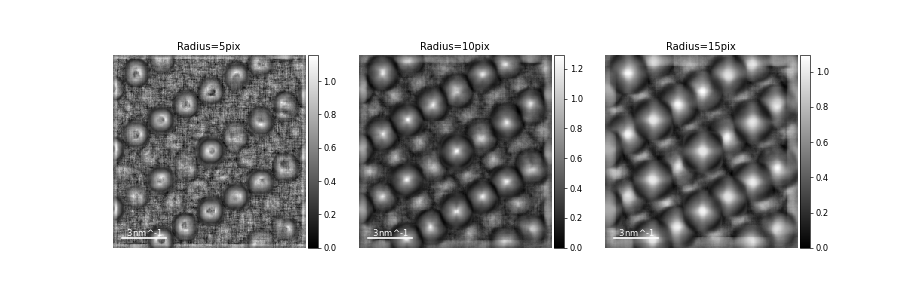

In [90]:
# lets just try to see what the effect of different disk radii is:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
one_pattern=filtered.inav[5,5]
hs.plot.plot_images([one_pattern.template_match_disk(r) for r in [5,10,15]], 
                    axes_decor="off",
                    scalebar="all",
                    label=["Radius=5pix","Radius=10pix","Radius=15pix"], fig=fig)
plt.show()

In [187]:
# template matching using a disk.  
temp = filtered.template_match_disk(disk_r=11, subtract_min=False)

[########################################] | 100% Completed | 107.13 ms
[########################################] | 100% Completed | 5.64 ss
[########################################] | 100% Completed | 5.67 s


In [188]:
temp.plot()

## Peak Finding 

Now we can see what a good value for peak finding is.  We can either use the interactive peak finding in hyperspy but I tend to just play with the vmin value with plotting until I get a reasonable min value.

WARNING | Hyperspy | Estimated number of bins using `bins='fd'` is too large (363). Capping the number of bins at `max_num_bins=250`. Consider using an alternative method for calculating the bins such as `bins='scott'`, or increasing the value of the `max_num_bins` keyword argument. (hyperspy.misc.hist_tools:97)


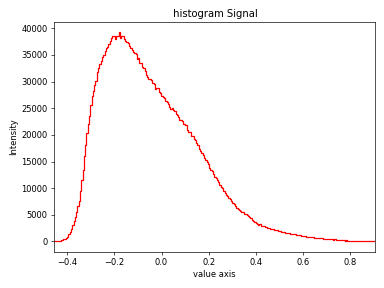

In [190]:
# lets look at the histgram for just a couple of points
temp.inav[3:10, 3:10].get_histogram().plot()

In [191]:
# Lets plot the data with an adjusted vmin 
temp.plot(vmin=.4)

In [209]:
# get the diffraction vectors
vect = temp.get_diffraction_vectors(threshold_abs=0.4,
                        distance=10, get_intensity=False)

[########################################] | 100% Completed | 102.54 ms
[########################################] | 100% Completed | 4.05 ss
[########################################] | 100% Completed | 4.07 s
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 106.14 ms
[########################################] | 100% Completed | 210.90 ms


In [210]:
#display the diffraction vectors
vect

<DiffractionVectors, title: , dimensions: (60, 40|ragged)>

In [220]:
#plot the diffraction vectors
vect.plot_diffraction_vectors_on_signal(s, vmax="95th")

/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/pyxem/signals/diffraction_vectors.py:915: VisibleDeprecationWarning: Function `plot_diffraction_vectors_on_signal()` is deprecated and will be removed in version 1.0.0. Use `pyxem.signals.DiffractionVectors.to_markers()` instead.
  since="0.17.0",


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 105.72 ms
[########################################] | 100% Completed | 106.12 ms
[########################################] | 100% Completed | 207.79 ms


## Setting a Basis and Determining Strain

First we filter the vactors based on their magnitude. This gets rid of the zero beam and weaker peaks farther out!

In [211]:
# filter the magnitude of the vectors
vect_filtered = vect.filter_magnitude(min_magnitude=3.5, max_magnitude=4.5)

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 100.85 ms
[########################################] | 100% Completed | 102.13 ms


In [195]:
# display the vectors
vect_filtered

<DiffractionVectors, title: , dimensions: (60, 40|ragged)>

Defining the basis vector far from the region of interest

In [198]:
# get a basis from the unstrained region
basis = vect.inav[4,4]

Show the number of vectors at every position.  You at least need 2 vectors at every position for strain mapping but more is usually better as long as they are good quality peaks.

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 104.28 ms
[########################################] | 100% Completed | 104.51 ms
[########################################] | 100% Completed | 206.41 ms
WARNING | Hyperspy | `signal_type='signal2d'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:743)


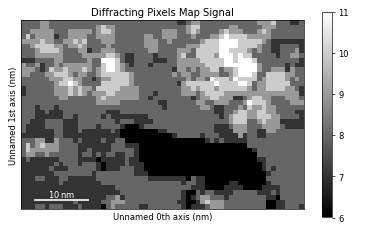

In [199]:
# use get_diffracting_pixels_map to plot the number of vectors at each position
vect.get_diffracting_pixels_map().plot()

 Filter the vectors to only those vectors around a basis vector.  Distance defines the max distance from a basis point for some point to be associated with that point.
 
 If multiple points are found the closest point is used.  If no points are found `np.nan` is returned and it is ignored.

In [100]:
#display basis
basis

<DiffractionVectors, title: , dimensions: (|ragged)>

In [207]:
# filter based on the basis
filtered_data = vect.filter_basis(basis.data[0])

WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 104.21 ms
[########################################] | 100% Completed | 206.95 ms


In [221]:
# display filtered data
vect

<DiffractionVectors, title: , dimensions: (60, 40|ragged)>

In [222]:
# white for current data, red for basis.
m = filtered_data.to_markers(edgecolor="w",facecolor="none", sizes=(40))
basis_markers = hs.plot.markers.Points(basis.data[0][:,::-1], edgecolor="r",facecolor="none", sizes=(40) )

filtered.plot(vmax="99th")
filtered.add_marker((m, basis_markers))



[########################################] | 100% Completed | 105.04 ms
[########################################] | 100% Completed | 105.81 ms
[########################################] | 100% Completed | 206.39 ms


In [104]:
from pyxem.generators.displacement_gradient_tensor_generator import get_DisplacementGradientMap

## Fitting an Ellipse for the Strain

Let's get a tensor strain map.  Basically we can determine the best elliptical transfromation to map from the basis set of vectors to the strained vectors.  We can also determine the residual and use that to improve the fits or indentify area where we are less confident about the fit.


In [229]:
# Lets get a tensor strain map.
strain_map, residual = get_DisplacementGradientMap(filtered_data, basis.data[0], return_residuals=True)

[########################################] | 100% Completed | 104.04 ms
[########################################] | 100% Completed | 206.53 ms
[########################################] | 100% Completed | 104.56 ms
[########################################] | 100% Completed | 104.87 ms
[########################################] | 100% Completed | 206.76 ms


In [255]:
# get the magnitude of the residual
std_err = (residual**2).sum(axis=-1)**0.5
std_err.set_signal_type()

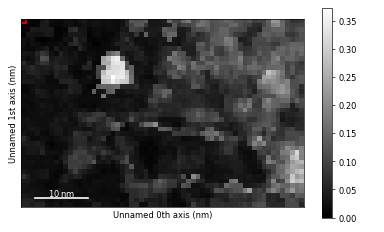

In [258]:
#plot the error.
std_err.plot()

In [259]:
# visualize the error and determine how to better fit the data.
m = filtered_data.to_markers(edgecolor="w",facecolor="none", sizes=(40))
basis_markers = hs.plot.markers.Points(basis.data[0][:,::-1], edgecolor="r",facecolor="none", sizes=(40) )

filtered.plot(navigator=std_err, vmax="99th")
filtered.add_marker((m, basis_markers))

[########################################] | 100% Completed | 107.28 ms
[########################################] | 100% Completed | 106.06 ms
[########################################] | 100% Completed | 208.72 ms


In [224]:
# get the strain maps.
maps = strain_map.get_strain_maps()

[########################################] | 100% Completed | 105.31 ms
[########################################] | 100% Completed | 102.46 ms
[########################################] | 100% Completed | 106.15 ms
[########################################] | 100% Completed | 101.72 ms
[########################################] | 100% Completed | 102.01 ms
[########################################] | 100% Completed | 204.98 ms
[########################################] | 100% Completed | 105.93 ms
[########################################] | 100% Completed | 210.70 ms


In [225]:
# Small bug! These axes are copied over so we do this manually
maps.axes_manager.signal_axes[0].scale =s.axes_manager.navigation_axes[0].scale
maps.axes_manager.signal_axes[1].scale =s.axes_manager.navigation_axes[1].scale
maps.axes_manager.signal_axes[0].units =s.axes_manager.navigation_axes[0].units
maps.axes_manager.signal_axes[1].units =s.axes_manager.navigation_axes[1].units


## Visualizing the Strain

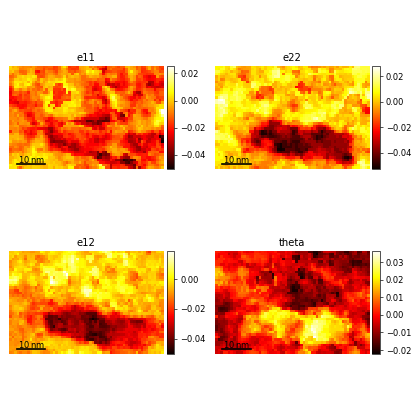

In [226]:
# use plot images to show the images.
import matplotlib.pyplot as plt
f= plt.figure(figsize=(7,7))
hs.plot.plot_images(maps,per_row=2,fig=f,
                    label=["e11","e22", "e12", "theta"],
                    tight_layout=True, cmap="hot", axes_decor="off", scalebar="all", scalebar_color="black")
plt.show()
# save the figure
fig.savefig("strainmaps.png", dpi=300)

In [262]:
m = filtered_data.to_markers(edgecolor="w",facecolor="none", sizes=(45), linewidth=4)
basis_markers = hs.plot.markers.Points(basis.data[0][:,::-1], edgecolor="r",facecolor="none", sizes=(45), linewidth=4 )

filtered.plot(navigator=maps.inav[2],vmax="99th", navigator_kwds =dict(cmap="hot"))
filtered.add_marker((m, basis_markers))


[########################################] | 100% Completed | 103.79 ms
[########################################] | 100% Completed | 104.53 ms
[########################################] | 100% Completed | 208.82 ms
